In [1]:
import pandas as pd
import numpy as np
import joblib
import re

# Sklearn imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from tqdm.auto import tqdm

/Users/cutiecelia/anaconda3/envs/dsa5205-p1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
file_path = '../data/final_df.csv' 
try:
    df_ori = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"*** ERROR: Cannot find {file_path} ***")


In [3]:
df = df_ori.copy()

# Sort by symbol and datetime
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by=['symbol', 'datetime'])
df = df.reset_index(drop=True)

df['lret_1m'] = df.groupby('symbol')['close'].transform(lambda s: np.log(s).diff())
df['y_target'] = df.groupby('symbol')['lret_1m'].shift(-1)

initial_rows = len(df)
df = df[(df['y_target'].abs() <= 0.2)]
df = df.dropna(subset=['y_target', 'lret_1m'])

print(f"(Dropped {initial_rows - len(df)} unusal/NaN y value)")

# --- Re-sort by datatime, symbol ---
df = df.sort_values(by=['datetime', 'symbol'])
df = df.reset_index(drop=True)

df

(Dropped 12 unusal/NaN y value)


,datetime,symbol,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,f_minsin,f_mincos,...,split_nonpos_flag,shares_out,log_shares_out,eps_surp_pct_final,div_amount,log_shares_out_iqr_outlier,eps_estimate_rz_8,eps_actual,lret_1m,y_target
0,2024-04-30 12:51:00,AMAT,0,1,0,0,0,0,-0.220697,-0.975342,...,1,830897024,20.538016,0.00,0.0,0,0.0,0.00,-0.000199,-0.000100
1,2024-04-30 12:51:00,AMD,0,1,0,0,0,0,-0.220697,-0.975342,...,1,1616140032,21.203306,2.04,0.0,0,0.0,0.62,0.000314,-0.000126
2,2024-04-30 12:51:00,AVGO,0,1,0,0,0,0,-0.220697,-0.975342,...,1,465308000,19.958210,0.00,0.0,0,0.0,0.00,-0.000334,0.000721
3,2024-04-30 12:51:00,MU,0,1,0,0,0,0,-0.220697,-0.975342,...,1,1107369984,20.825254,0.00,0.0,0,0.0,0.00,0.000698,-0.000698
4,2024-04-30 12:51:00,NVDA,0,1,0,0,0,0,-0.220697,-0.975342,...,1,2500000000,21.639557,0.00,0.0,0,0.0,0.00,-0.000769,-0.000907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324883,2025-10-28 15:58:00,AMAT,0,1,0,0,0,0,-0.861629,-0.507538,...,1,796642427,20.495916,0.00,0.0,0,0.0,0.00,-0.000461,-0.000132
324884,2025-10-28 15:58:00,AMD,0,1,0,0,0,0,-0.861629,-0.507538,...,1,1633284837,21.213859,0.00,0.0,0,0.0,0.00,-0.000698,-0.001316
324885,2025-10-28 15:58:00,AVGO,0,1,0,0,0,0,-0.861629,-0.507538,...,1,4722365022,22.275576,0.00,0.0,0,0.0,0.00,0.000161,0.000375
324886,2025-10-28 15:58:00,MU,0,1,0,0,0,0,-0.861629,-0.507538,...,1,1122466035,20.838794,0.00,0.0,0,0.0,0.00,0.000270,-0.000135


In [4]:
df[["datetime", "symbol", 'fz_lret_1_rolling', "lret_1m", "y_target"]]

,datetime,symbol,fz_lret_1_rolling,lret_1m,y_target
0,2024-04-30 12:51:00,AMAT,-0.194539,-0.000199,-0.000100
1,2024-04-30 12:51:00,AMD,0.722399,0.000314,-0.000126
2,2024-04-30 12:51:00,AVGO,-0.248127,-0.000334,0.000721
3,2024-04-30 12:51:00,MU,0.793029,0.000698,-0.000698
4,2024-04-30 12:51:00,NVDA,-1.007944,-0.000769,-0.000907
...,...,...,...,...,...
324883,2025-10-28 15:58:00,AMAT,-0.714656,-0.000461,-0.000132
324884,2025-10-28 15:58:00,AMD,-0.811072,-0.000698,-0.001316
324885,2025-10-28 15:58:00,AVGO,-0.057482,0.000161,0.000375
324886,2025-10-28 15:58:00,MU,0.281664,0.000270,-0.000135


## Data Cleaning

In [5]:
y = df['y_target']
X = df.drop(columns=[
    'y_target', 'lret_1m', 'datetime', 'symbol',  
    'year', 'month', 'day', 'minute', 'minute_of_day'
], errors='ignore')

print(f"X original shape: {X.shape}")

# --- Find bad Cols with wrong data ---
desc = X.describe(percentiles=[0.99]).T
bad_cols = []

# std > 1000
bad_cols += desc.index[desc['std'] > 1e3].tolist()
# 99% > 1000
bad_cols += desc.index[desc['99%'].abs() > 1e3].tolist()
# Max > 1,000,000
bad_cols += desc.index[desc['max'].abs() > 1e6].tolist()
# Constant columns
bad_cols += desc.index[desc['std'] == 0].tolist()

bad_cols_set = sorted(set(bad_cols))
print(f"--- Dropping {len(bad_cols_set)} bad cols ---")
for col in bad_cols_set:
    print(f"  - {col}")

# --- Drop bad cols ---
X_cleaned = X.drop(columns=bad_cols_set)

print(f"\n--- X cleaned ---")
print(f"X (cleaned) shape: {X_cleaned.shape}")

X original shape: (324888, 184)
--- Dropping 37 bad cols ---
  - cnt_15m_rs
  - cnt_30m_rs
  - cnt_5m_rs
  - cnt_60m_rs
  - div_negative_flag
  - dow_5
  - dow_6
  - eps_actual_iqr_outlier
  - eps_estimate_iqr_outlier
  - fz_vol_ratio_60
  - mins_since_last_news_rs
  - morning_n_rs
  - morning_source_div_rs
  - morning_tone_mean_rs
  - morning_tone_sum_rs
  - n_news_ewm_hl15_is_zero
  - n_news_ewm_hl15_rs
  - n_news_ewm_hl5_is_zero
  - n_news_ewm_hl5_rs
  - n_news_rs
  - n_pos_raw_rs
  - overnight_n_rs
  - overnight_source_div_rs
  - overnight_tone_mean_rs
  - overnight_tone_sum_rs
  - shares_out
  - shares_out_ffill
  - shares_out_nonpos_flag
  - split_flag
  - surprise_tone_mean_rs
  - tone_ewm15_rs
  - tone_ewm30_rs
  - tone_mean_delta_rs
  - tone_mean_ewm_hl15_rs
  - tone_mean_rs
  - tone_sum_rs
  - volume

--- X cleaned ---
X (cleaned) shape: (324888, 147)


## Split Data

In [6]:
split_ratio = 1.0 / 1.5 
split_index = int(len(X_cleaned) * split_ratio)

X_val = X_cleaned.iloc[:split_index]
y_val = y.iloc[:split_index]

X_test = X_cleaned.iloc[split_index:]
y_test = y.iloc[split_index:]

print(f"--- Data Splitting done ---")
print(f" Validation set (X_val, y_val) shape: {X_val.shape}, {y_val.shape}")
print(f" Testing set (X_test, y_test) shape: {X_test.shape}, {y_test.shape}")

--- Data Splitting done ---
 Validation set (X_val, y_val) shape: (216592, 147), (216592,)
 Testing set (X_test, y_test) shape: (108296, 147), (108296,)


In [7]:
class QuantileClipper(BaseEstimator, TransformerMixin):
    def __init__(self, lower=0.005, upper=0.995):
        self.lower = lower
        self.upper = upper
        self.q_low_ = None
        self.q_high_ = None

    def fit(self, X, y=None):
        self.q_low_  = np.nanpercentile(X, self.lower * 100, axis=0) 
        self.q_high_ = np.nanpercentile(X, self.upper * 100, axis=0)
        return self

    def transform(self, X):
        return np.clip(X, self.q_low_, self.q_high_)

## Grid Search CV with Sharp Ratio

### Applied Scaler only to raw features

In [8]:
def split_columns_for_scaling(X: pd.DataFrame):
    # Regex to find already-processed columns
    patterns = [
        r'^fz_', r'_z_', r'(?:^|_)tanh', r'(?:^|_)arctanh',
        r'(?:^|_)sin$', r'(?:^|_)cos$', r'^dow_\d+$',
        r'^has_news$', r'(?:^|_)log', r'(?:^|_)ln', r'(?:^|_)ewm',
        r'^tone_', r'_flag$', r'_iqr_outlier$'
    ]
    regex = re.compile('|'.join(patterns))

    name_matched = [c for c in X.columns if regex.search(c)]
    # Find all 0/1 binary columns
    binary_cols = [c for c in X.columns if X[c].nunique(dropna=True) <= 2]

    no_scale_cols = sorted(set(name_matched + binary_cols))
    scale_cols = [c for c in X.columns if c not in no_scale_cols]
    return no_scale_cols, scale_cols

no_scale_cols, scale_cols = split_columns_for_scaling(X_val)

print(f"--- Feature separation complete ---")
print(f"Will scale {len(scale_cols)} 'raw' columns (e.g., 'close', 'high'...)")
print(f"Will skip {len(no_scale_cols)} 'processed' columns (e.g., 'fz_...', 'dow_0'...)")

--- Feature separation complete ---
Will scale 44 'raw' columns (e.g., 'close', 'high'...)
Will skip 103 'processed' columns (e.g., 'fz_...', 'dow_0'...)


## Coarse Hyperparameter Grid Search on LASSO

In [ ]:
# --- Preprocessor (ColumnTransformer) ---

raw_branch_pipeline = Pipeline([
    ("clip", QuantileClipper(lower=0.005, upper=0.995)),
    ("sc",   MaxAbsScaler()),  
    # ("sc",   StandardScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("raw_scaler", raw_branch_pipeline, scale_cols),
        ("passthrough_features", "passthrough", no_scale_cols),
    ],
    remainder="drop" # Safety net
)

def build_final_pipe(alpha: float, tol: float, max_iter: int) -> Pipeline:
    return Pipeline([
        ("preprocessor", preprocessor),
        ("reg", TransformedTargetRegressor(
            regressor=Lasso(alpha=alpha, tol=tol, max_iter=max_iter, warm_start=True),
            transformer=StandardScaler()
        )),
    ])

def calculate_sharpe(pnl_series: pd.Series) -> float:
    std = pnl_series.std()
    return 0.0 if std == 0 else pnl_series.mean() / std

def run_sharpe_grid(param_grid, splitter):
    print("\n--- Manual Sharpe grid ---")
    validation_results, param_lookup = {}, {}

    for params in param_grid:
        alpha, tol, max_iter = params["alpha"], params["tol"], params["max_iter"]
        key = f"alpha={alpha:.1e} | tol={tol:.1e} | max_iter={max_iter}"
        print(f"  Testing {key} ...")

        pipe = build_final_pipe(alpha=alpha, tol=tol, max_iter=max_iter)
        fold_pnls = []

        for train_idx, val_idx in splitter.split(X_val):
            X_tr, X_te = X_val.iloc[train_idx], X_val.iloc[val_idx]
            y_tr, y_te = y_val.iloc[train_idx], y_val.iloc[val_idx]

            pipe.fit(X_tr, y_tr)
            preds = pipe.predict(X_te)

            signals = np.sign(preds)
            pnl = pd.Series(signals, index=y_te.index) * y_te
            fold_pnls.append(pnl)

        validation_results[key] = pd.concat(fold_pnls)
        param_lookup[key] = params

    sharpe_scores = {k: calculate_sharpe(pnl) for k, pnl in validation_results.items()}
    sharpe_df = pd.Series(sharpe_scores, name="Sharpe_Ratio").sort_values(ascending=False)
    print(sharpe_df)

    best_key = sharpe_df.idxmax()
    return param_lookup[best_key], sharpe_df

tscv = TimeSeriesSplit(n_splits=10)  

param_grid = [
    # {"alpha": 1e-7, "tol": 2e-3, "max_iter": 20000},
    # {"alpha": 1e-6, "tol": 1e-3, "max_iter": 20000},
    # {"alpha": 1e-5, "tol": 2e-3, "max_iter": 50000},
    # {"alpha": 3e-5, "tol": 2e-3, "max_iter": 20000},
    {"alpha": 1e-4, "tol": 1e-3, "max_iter": 10000},
    {"alpha": 3e-4, "tol": 1e-3, "max_iter": 10000},
    {"alpha": 1e-3, "tol": 5e-4, "max_iter": 10000},
    {"alpha": 1e-2, "tol": 1e-4, "max_iter": 10000},  
    {"alpha": 5e-2, "tol": 1e-4, "max_iter": 10000},
    {"alpha": 0.1, "tol": 1e-4, "max_iter": 10000},
]

In [10]:
best_params, sharpe_df = run_sharpe_grid(param_grid, tscv)

best_alpha_by_sharpe = best_params["alpha"]
best_tol_by_sharpe = best_params["tol"]
best_iter_by_sharpe = best_params["max_iter"]
print(f"\nBest Alpha (SR): {best_alpha_by_sharpe}")
print(f"Best Tol   (SR): {best_tol_by_sharpe}")
print(f"Best Iter  (SR): {best_iter_by_sharpe}")
print(f"Best SR    (grid): {sharpe_df.max():.6f}")

# --- Final evaluation on train/test ---
print("\n--- Retraining best LASSO and evaluating ---")
best_pipe = build_final_pipe(best_alpha_by_sharpe, best_tol_by_sharpe, best_iter_by_sharpe)
best_pipe.fit(X_val, y_val)

val_preds = best_pipe.predict(X_val)
val_pnl = pd.Series(np.sign(val_preds), index=y_val.index) * y_val
val_sharpe = calculate_sharpe(val_pnl)

test_preds = best_pipe.predict(X_test)
test_pnl = pd.Series(np.sign(test_preds), index=y_test.index) * y_test
test_sharpe = calculate_sharpe(test_pnl)

print(f"In-sample (train/val) Sharpe: {val_sharpe:.6f}")
print(f"Out-of-sample (test) Sharpe : {test_sharpe:.6f}")


--- Manual Sharpe grid ---
  Testing alpha=1.0e-04 | tol=1.0e-03 | max_iter=10000 ...


/Users/cutiecelia/anaconda3/envs/dsa5205-p1/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.986e+03, tolerance: 3.938e+01
  model = cd_fast.enet_coordinate_descent(


  Testing alpha=3.0e-04 | tol=1.0e-03 | max_iter=10000 ...
  Testing alpha=1.0e-03 | tol=5.0e-04 | max_iter=10000 ...
  Testing alpha=1.0e-02 | tol=1.0e-04 | max_iter=10000 ...
  Testing alpha=5.0e-02 | tol=1.0e-04 | max_iter=10000 ...
  Testing alpha=1.0e-01 | tol=1.0e-04 | max_iter=10000 ...
alpha=3.0e-04 | tol=1.0e-03 | max_iter=10000    0.001165
alpha=1.0e-03 | tol=5.0e-04 | max_iter=10000    0.001161
alpha=1.0e-04 | tol=1.0e-03 | max_iter=10000   -0.001297
alpha=1.0e-02 | tol=1.0e-04 | max_iter=10000   -0.003019
alpha=1.0e-01 | tol=1.0e-04 | max_iter=10000   -0.003252
alpha=5.0e-02 | tol=1.0e-04 | max_iter=10000   -0.003388
Name: Sharpe_Ratio, dtype: float64

Best Alpha (SR): 0.0003
Best Tol   (SR): 0.001
Best Iter  (SR): 10000
Best SR    (grid): 0.001165

--- Retraining best LASSO and evaluating ---
In-sample (train/val) Sharpe: 0.014660
Out-of-sample (test) Sharpe : -0.004735


## Fine Tune

In [ ]:
param_grid_fine = [
    {"alpha": 3e-4, "tol": 1e-4, "max_iter": 10000},
    {"alpha": 5e-4, "tol": 1e-4, "max_iter": 10000},
    {"alpha": 1e-3, "tol": 1e-4, "max_iter": 10000},
    {"alpha": 3e-3, "tol": 1e-4, "max_iter": 10000},
    {"alpha": 5e-3, "tol": 1e-4, "max_iter": 10000},
    {"alpha": 0.01, "tol": 1e-4, "max_iter": 10000},
]

best_params, sharpe_df = run_sharpe_grid(param_grid_fine, tscv)

best_alpha_by_sharpe = best_params["alpha"]
best_tol_by_sharpe = best_params["tol"]
best_iter_by_sharpe = best_params["max_iter"]
print(f"\nBest Alpha (SR): {best_alpha_by_sharpe}")
print(f"Best Tol   (SR): {best_tol_by_sharpe}")
print(f"Best Iter  (SR): {best_iter_by_sharpe}")
print(f"Best SR    (grid): {sharpe_df.max():.6f}")

# --- Final evaluation on train/test ---
print("\n--- Retraining best LASSO and evaluating ---")
best_pipe = build_final_pipe(best_alpha_by_sharpe, best_tol_by_sharpe, best_iter_by_sharpe)
best_pipe.fit(X_val, y_val)

val_preds = best_pipe.predict(X_val)
val_pnl = pd.Series(np.sign(val_preds), index=y_val.index) * y_val
val_sharpe = calculate_sharpe(val_pnl)

test_preds = best_pipe.predict(X_test)
test_pnl = pd.Series(np.sign(test_preds), index=y_test.index) * y_test
test_sharpe = calculate_sharpe(test_pnl)

print(f"In-sample (train/val) Sharpe: {val_sharpe:.6f}")
print(f"Out-of-sample (test) Sharpe : {test_sharpe:.6f}")



--- Manual Sharpe grid ---
  Testing alpha=3.0e-04 | tol=1.0e-04 | max_iter=10000 ...
  Testing alpha=5.0e-04 | tol=1.0e-04 | max_iter=10000 ...
  Testing alpha=1.0e-03 | tol=1.0e-04 | max_iter=10000 ...
  Testing alpha=3.0e-03 | tol=1.0e-04 | max_iter=10000 ...
  Testing alpha=5.0e-03 | tol=1.0e-04 | max_iter=10000 ...
  Testing alpha=1.0e-02 | tol=1.0e-04 | max_iter=10000 ...
alpha=3.0e-04 | tol=1.0e-04 | max_iter=10000    0.001198
alpha=1.0e-03 | tol=1.0e-04 | max_iter=10000    0.001184
alpha=5.0e-04 | tol=1.0e-04 | max_iter=10000    0.000127
alpha=3.0e-03 | tol=1.0e-04 | max_iter=10000   -0.000401
alpha=5.0e-03 | tol=1.0e-04 | max_iter=10000   -0.001908
alpha=1.0e-02 | tol=1.0e-04 | max_iter=10000   -0.003019
Name: Sharpe_Ratio, dtype: float64

Best Alpha (SR): 0.0003
Best Tol   (SR): 0.0001
Best Iter  (SR): 10000
Best SR    (grid): 0.001198

--- Retraining best LASSO and evaluating ---
In-sample (train/val) Sharpe: 0.014719
Out-of-sample (test) Sharpe : -0.005122


# Draw Plots of LASSO feature 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. using the best_pipe retrained on full validation set
best_pipe = build_final_pipe(best_alpha_by_sharpe, tol = best_tol_by_sharpe, max_iter = best_iter_by_sharpe)
best_pipe.fit(X_val, y_val)

lasso = best_pipe.named_steps["reg"].regressor_   # 取出 LASSO 模型
coefs = lasso.coef_

# 2. Prepare feature names (ColumnTransformer output order = scale_cols first, no_scale_cols second)
feature_names = scale_cols + no_scale_cols
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs
})
coef_df["abs_coef"] = coef_df["coefficient"].abs()


/var/folders/z_/z1x1mkg9173616gjxbdhbf4c0000gn/T/ipykernel_53563/2997065800.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


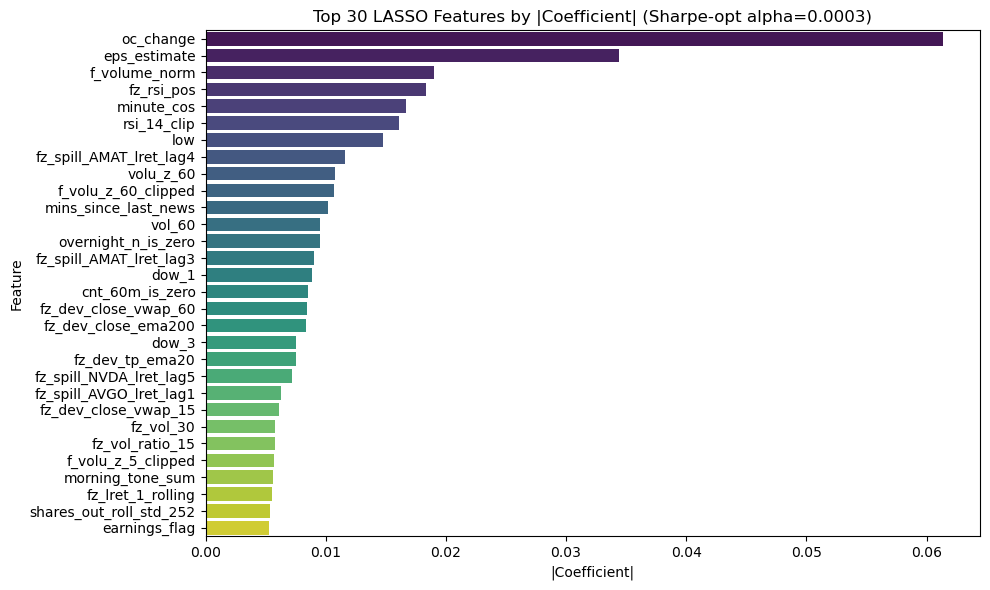

In [ ]:
# 3. visualize top LASSO features
top_n = 30  # adjustable
top_features = coef_df.sort_values("abs_coef", ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_features,
    x="abs_coef",
    y="feature",
    orient="h",
    palette="viridis"
)
plt.title(f"Top {top_n} LASSO Features by |Coefficient| (Sharpe-opt alpha={best_alpha_by_sharpe})")
plt.xlabel("|Coefficient|")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [14]:
# print number of non-zero coefficients
non_zero_coefs = coef_df[coef_df['coefficient'] != 0]
print(f"Number of features with non-zero coefficients: {len(non_zero_coefs)}")

Number of features with non-zero coefficients: 75


In [15]:
# print top-75 features
top_75_features = coef_df.sort_values("abs_coef", ascending=False).head(75)
print(top_75_features)

                          feature   coefficient      abs_coef
7                       oc_change -6.136667e-02  6.136667e-02
35                   eps_estimate -3.439569e-02  3.439569e-02
3                   f_volume_norm  1.901432e-02  1.901432e-02
82                     fz_rsi_pos -1.833834e-02  1.833834e-02
119                    minute_cos -1.671377e-02  1.671377e-02
..                            ...           ...           ...
105       fz_spill_NVDA_lret_lag3 -1.808635e-04  1.808635e-04
100         fz_spill_MU_lret_lag3  1.282540e-04  1.282540e-04
44        5d_before_earnings_flag  5.622503e-05  5.622503e-05
134                   split_ratio -1.161344e-16  1.161344e-16
128  overnight_source_div_is_zero  1.287280e-17  1.287280e-17

[75 rows x 3 columns]


In [16]:
# print the list of features with non-zero coefficients
non_zero_feature_list = non_zero_coefs['feature'].tolist()
print("Features with non-zero coefficients:")
for feature in non_zero_feature_list:
    print(feature)

Features with non-zero coefficients:
f_minsin
f_mincos
f_volume_norm
low
oc_change
rsi_14_clip
vol_60
morning_tone_sum
mins_since_last_news
overnight_tone_mean
eps_estimate
shares_out_roll_std_252
5d_before_earnings_flag
cnt_15m_is_zero
cnt_30m_is_zero
cnt_60m_is_zero
dow_0
dow_1
dow_3
earnings_flag
f_volu_z_15_clipped
f_volu_z_5_clipped
f_volu_z_60_clipped
fz_dev_close_ema200
fz_dev_close_vwap_15
fz_dev_close_vwap_60
fz_dev_tp_ema20
fz_hl_over_atr20
fz_lret_15_rolling
fz_lret_1_rolling
fz_lret_30_rolling
fz_lret_5_rolling
fz_lret_60_rolling
fz_macd_hist
fz_rsi_pos
fz_spill_AMAT_lret_lag1
fz_spill_AMAT_lret_lag2
fz_spill_AMAT_lret_lag3
fz_spill_AMAT_lret_lag4
fz_spill_AMAT_lret_lag5
fz_spill_AMD_lret_lag1
fz_spill_AMD_lret_lag2
fz_spill_AMD_lret_lag3
fz_spill_AMD_lret_lag4
fz_spill_AMD_lret_lag5
fz_spill_AVGO_lret_lag1
fz_spill_AVGO_lret_lag2
fz_spill_AVGO_lret_lag4
fz_spill_AVGO_lret_lag5
fz_spill_MU_lret_lag1
fz_spill_MU_lret_lag2
fz_spill_MU_lret_lag3
fz_spill_MU_lret_lag4
fz_spill_

In [24]:
# save top-75 features to csv
top_75_features.to_csv('../data/lasso_top_75_features.csv', index=False)

# 30-minute rolling window backtesting

In [ ]:
# --- 30-minute rolling backtest (LASSO version) ---

BEST_ALPHA = 1e-3        
BEST_TOL = 1e-3
BEST_MAX_ITER = 50000
ROLLING_WINDOW_MINUTES = 30
MIN_TRAIN_ROWS = 15 * 5  

rolling_preprocessor = ColumnTransformer(
    transformers=[
        ("raw_scaler", raw_branch_pipeline, scale_cols),
        ("passthrough_features", "passthrough", no_scale_cols),
    ],
    remainder="drop"
)

def build_rolling_pipe():
    """Reuse the same pipeline对象以触发 LASSO 的 warm_start."""
    return Pipeline([
        ("preprocessor", rolling_preprocessor),
        ("reg", TransformedTargetRegressor(
            regressor=Lasso(
                alpha=BEST_ALPHA,
                tol=BEST_TOL,
                max_iter=BEST_MAX_ITER,
                warm_start=True
            ),
            transformer=StandardScaler()
        )),
    ])

rolling_pipe = build_rolling_pipe()

# --- Prepare full history aligned to validation/train columns ---
df_backtest = df.set_index("datetime").sort_index()
X_full_history = df_backtest[X_val.columns]
y_full_history = df_backtest["y_target"]
meta_full_history = df_backtest[["symbol"]]

test_original_indices = X_test.index
test_datetimes = (
    df.loc[test_original_indices, "datetime"]
      .sort_values()
      .unique()
)

print(f"--- Loading {len(test_datetimes)} min rolling window backtest ---")
print(f"Testing period: {test_datetimes.min()}  →  {test_datetimes.max()}")
print(f"Rolling Window: {ROLLING_WINDOW_MINUTES} min")
print(f"Best Alpha / Tol / Iter: {BEST_ALPHA}, {BEST_TOL}, {BEST_MAX_ITER}")

results_list = []

for current_dt in tqdm(test_datetimes):
    train_start_dt = current_dt - pd.Timedelta(minutes=ROLLING_WINDOW_MINUTES)
    train_end_dt   = current_dt - pd.Timedelta(minutes=1)

    X_tr = X_full_history.loc[train_start_dt:train_end_dt]
    y_tr = y_full_history.loc[train_start_dt:train_end_dt]

    if len(X_tr) < MIN_TRAIN_ROWS:
        continue

    X_te = X_full_history.loc[current_dt]
    if isinstance(X_te, pd.Series):
        X_te = X_te.to_frame().T

    rolling_pipe.fit(X_tr, y_tr)  
    preds = rolling_pipe.predict(X_te)

    actuals = y_full_history.loc[current_dt]
    meta_rows = meta_full_history.loc[current_dt]

    if isinstance(meta_rows, pd.Series):
        results_list.append({
            "datetime": current_dt,
            "symbol": meta_rows["symbol"],
            "predicted_log_return": preds[0],
            "actual_log_return": actuals
        })
    else:
        for i in range(len(meta_rows)):
            results_list.append({
                "datetime": current_dt,
                "symbol": meta_rows.iloc[i]["symbol"],
                "predicted_log_return": preds[i],
                "actual_log_return": actuals.iloc[i]
            })

print("\n--- Backtesting done! Creating final DataFrame ... ---")
results_df = pd.DataFrame(results_list)

# Long-only 
results_df["positive_prediction"] = results_df["predicted_log_return"].clip(lower=0)
minute_sum = results_df.groupby("datetime")["positive_prediction"].transform("sum")
results_df["weight_relative"] = np.where(
    minute_sum == 0,
    0.0,
    results_df["positive_prediction"] / minute_sum
)
results_df.drop(columns=["positive_prediction"], inplace=True)

# Sign-based weights
results_df["weight_sign"] = np.sign(results_df["predicted_log_return"])

print("--- Final DataFrame created ---")
print(results_df.head())
print(f"\nTotal rows: {len(results_df)}")


--- Loading 21660 min rolling window backtest ---
Testing period: 2025-04-29 15:59:00  →  2025-10-28 15:58:00
Rolling Window: 30 min
Best Alpha / Tol / Iter: 0.001, 0.001, 50000


 34%|███▍      | 7449/21660 [07:18<26:53,  8.81it/s]  /Users/cutiecelia/anaconda3/envs/dsa5205-p1/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 34%|███▍      | 7451/21660 [07:19<43:51,  5.40it/s]/Users/cutiecelia/anaconda3/envs/dsa5205-p1/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 34%|███▍      | 7452/21660 [07:20<1:02:48,  3.77it/s]/Users/cutiecelia/anaconda3/envs/dsa5205-p1/lib/python3.12/site-packages/skl


--- Backtesting done! Creating final DataFrame ... ---
--- Final DataFrame created ---
             datetime symbol  predicted_log_return  actual_log_return  \
0 2025-04-29 15:59:00   AMAT              0.000631          -0.014007   
1 2025-04-29 15:59:00    AMD              0.002986          -0.006581   
2 2025-04-29 15:59:00   AVGO              0.001802          -0.008008   
3 2025-04-29 15:59:00     MU              0.000672          -0.019444   
4 2025-04-29 15:59:00   NVDA              0.000060          -0.025525   

   weight_relative  weight_sign  
0         0.102517          1.0  
1         0.485454          1.0  
2         0.292890          1.0  
3         0.109326          1.0  
4         0.009812          1.0  

Total rows: 99749


In [20]:
results_df

,datetime,symbol,predicted_log_return,actual_log_return,weight_relative,weight_sign
0,2025-04-29 15:59:00,AMAT,0.000631,-0.014007,0.102517,1.0
1,2025-04-29 15:59:00,AMD,0.002986,-0.006581,0.485454,1.0
2,2025-04-29 15:59:00,AVGO,0.001802,-0.008008,0.292890,1.0
3,2025-04-29 15:59:00,MU,0.000672,-0.019444,0.109326,1.0
4,2025-04-29 15:59:00,NVDA,0.000060,-0.025525,0.009812,1.0
...,...,...,...,...,...,...
99744,2025-10-28 15:58:00,AMAT,0.001543,-0.000132,0.189375,1.0
99745,2025-10-28 15:58:00,AMD,0.002466,-0.001316,0.302634,1.0
99746,2025-10-28 15:58:00,AVGO,0.001793,0.000375,0.220000,1.0
99747,2025-10-28 15:58:00,MU,0.001620,-0.000135,0.198828,1.0


In [ ]:
# --- 30-minute rolling backtest (LASSO version) ---

BEST_ALPHA = 3e-4        
BEST_TOL = 1e-3
BEST_MAX_ITER = 100000
ROLLING_WINDOW_MINUTES = 30
MIN_TRAIN_ROWS = 15 * 5  # 确保至少覆盖 15 分钟 * 5 只股票

# 复用与调参一致的预处理器，只初始化一次
rolling_preprocessor = ColumnTransformer(
    transformers=[
        ("raw_scaler", raw_branch_pipeline, scale_cols),
        ("passthrough_features", "passthrough", no_scale_cols),
    ],
    remainder="drop"
)

def build_rolling_pipe():
    """Reuse the same pipeline对象以触发 LASSO 的 warm_start."""
    return Pipeline([
        ("preprocessor", rolling_preprocessor),
        ("reg", TransformedTargetRegressor(
            regressor=Lasso(
                alpha=BEST_ALPHA,
                tol=BEST_TOL,
                max_iter=BEST_MAX_ITER,
                warm_start=True
            ),
            transformer=StandardScaler()
        )),
    ])

rolling_pipe = build_rolling_pipe()

# --- Prepare full history aligned to validation/train columns ---
df_backtest = df.set_index("datetime").sort_index()
X_full_history = df_backtest[X_val.columns]
y_full_history = df_backtest["y_target"]
meta_full_history = df_backtest[["symbol"]]

test_original_indices = X_test.index
test_datetimes = (
    df.loc[test_original_indices, "datetime"]
      .sort_values()
      .unique()
)

print(f"--- Loading {len(test_datetimes)} min rolling window backtest ---")
print(f"Testing period: {test_datetimes.min()}  →  {test_datetimes.max()}")
print(f"Rolling Window: {ROLLING_WINDOW_MINUTES} min")
print(f"Best Alpha / Tol / Iter: {BEST_ALPHA}, {BEST_TOL}, {BEST_MAX_ITER}")

results_list = []

for current_dt in tqdm(test_datetimes):
    train_start_dt = current_dt - pd.Timedelta(minutes=ROLLING_WINDOW_MINUTES)
    train_end_dt   = current_dt - pd.Timedelta(minutes=1)

    X_tr = X_full_history.loc[train_start_dt:train_end_dt]
    y_tr = y_full_history.loc[train_start_dt:train_end_dt]

    if len(X_tr) < MIN_TRAIN_ROWS:
        continue

    X_te = X_full_history.loc[current_dt]
    if isinstance(X_te, pd.Series):
        X_te = X_te.to_frame().T

    rolling_pipe.fit(X_tr, y_tr)  # warm_start 会沿用上一轮系数
    preds = rolling_pipe.predict(X_te)

    actuals = y_full_history.loc[current_dt]
    meta_rows = meta_full_history.loc[current_dt]

    if isinstance(meta_rows, pd.Series):
        results_list.append({
            "datetime": current_dt,
            "symbol": meta_rows["symbol"],
            "predicted_log_return": preds[0],
            "actual_log_return": actuals
        })
    else:
        for i in range(len(meta_rows)):
            results_list.append({
                "datetime": current_dt,
                "symbol": meta_rows.iloc[i]["symbol"],
                "predicted_log_return": preds[i],
                "actual_log_return": actuals.iloc[i]
            })

print("\n--- Backtesting done! Creating final DataFrame ... ---")
results_df = pd.DataFrame(results_list)

# Long-only 权重（预测值<0视为0，再归一化）
results_df["positive_prediction"] = results_df["predicted_log_return"].clip(lower=0)
minute_sum = results_df.groupby("datetime")["positive_prediction"].transform("sum")
results_df["weight_relative"] = np.where(
    minute_sum == 0,
    0.0,
    results_df["positive_prediction"] / minute_sum
)
results_df.drop(columns=["positive_prediction"], inplace=True)

# Sign-based 权重
results_df["weight_sign"] = np.sign(results_df["predicted_log_return"])

print("--- Final DataFrame created ---")
print(results_df.head())
print(f"\nTotal rows: {len(results_df)}")


--- Loading 21660 min rolling window backtest ---
Testing period: 2025-04-29 15:59:00  →  2025-10-28 15:58:00
Rolling Window: 30 min
Best Alpha / Tol / Iter: 0.0003, 0.001, 100000


 19%|█▉        | 4108/21660 [12:50<46:29,  6.29it/s]  /Users/cutiecelia/anaconda3/envs/dsa5205-p1/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.834e-01, tolerance: 1.500e-01
  model = cd_fast.enet_coordinate_descent(
 19%|█▉        | 4118/21660 [12:57<2:25:46,  2.01it/s]/Users/cutiecelia/anaconda3/envs/dsa5205-p1/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.571e-01, tolerance: 1.500e-01
  model = cd_fast.enet_coordinate_descent(
 19%|█▉        | 4174/21660 [13:11<2:58:46,  1.63it/s]/Users/cutiecelia/anaconda3/envs/dsa5205-p1/lib/python3.12/site-packages/s


--- Backtesting done! Creating final DataFrame ... ---
--- Final DataFrame created ---
             datetime symbol  predicted_log_return  actual_log_return  \
0 2025-04-29 15:59:00   AMAT              0.001567          -0.014007   
1 2025-04-29 15:59:00    AMD              0.004571          -0.006581   
2 2025-04-29 15:59:00   AVGO              0.002464          -0.008008   
3 2025-04-29 15:59:00     MU              0.001190          -0.019444   
4 2025-04-29 15:59:00   NVDA              0.000292          -0.025525   

   weight_relative  weight_sign  
0         0.155424          1.0  
1         0.453262          1.0  
2         0.244344          1.0  
3         0.118016          1.0  
4         0.028953          1.0  

Total rows: 99749


In [23]:
# head results_df
results_df.head(5)

,datetime,symbol,predicted_log_return,actual_log_return,weight_relative,weight_sign
0,2025-04-29 15:59:00,AMAT,0.001567,-0.014007,0.155424,1.0
1,2025-04-29 15:59:00,AMD,0.004571,-0.006581,0.453262,1.0
2,2025-04-29 15:59:00,AVGO,0.002464,-0.008008,0.244344,1.0
3,2025-04-29 15:59:00,MU,0.001190,-0.019444,0.118016,1.0
4,2025-04-29 15:59:00,NVDA,0.000292,-0.025525,0.028953,1.0


In [22]:
# output results_df to csv
results_df.to_csv('../data/lasso_rolling_backtest_results.csv', index=False)